# Speech Command Recognition: Model Comparison

This notebook compares three approaches for speech command recognition:
1. **Baseline CNN** using Spectrogram (STFT) features
2. **CNN with MFCC** features
3. **Hidden Markov Model (HMM)** with MFCC features

**Authors:** Nicholas Hefner, Arthur Ho, Hsuan-Yu Lin

## Overview
- **Dataset:** Google Speech Commands Dataset (mini version)
- **Commands:** 8 classes (down, go, left, no, right, stop, up, yes)
- **Purpose:** Compare deep learning and statistical approaches for audio classification


---
# Part 0: Setup and Data Loading
---


## 0.1 Import Libraries


In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import librosa
import librosa.display
from tqdm import tqdm

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# HMM
from hmmlearn import hmm

# Set seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Create directories
os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)

print(f"TensorFlow version: {tf.__version__}")
print("Libraries imported successfully!")


2025-12-07 16:16:46.853289: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 16:16:46.990925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 16:16:48.797793: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0
Libraries imported successfully!


## 0.2 Load Dataset


In [2]:
# Dataset path - check multiple possible locations
possible_paths = [
    'data/mini_speech_commands_extracted/mini_speech_commands',
    'data/mini_speech_commands_extracted/mini_speech_commands_extracted/mini_speech_commands',
    'data/mini_speech_commands',
]

data_dir = None
for path in possible_paths:
    if pathlib.Path(path).exists():
        data_dir = pathlib.Path(path)
        break

# Download dataset if not found
if data_dir is None or not data_dir.exists():
    print("Downloading dataset...")
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data'
    )
    # Check paths again after download
    for path in possible_paths:
        if pathlib.Path(path).exists():
            data_dir = pathlib.Path(path)
            break
    print("Dataset downloaded!")

print(f"Dataset location: {data_dir}")

# Audio parameters
SAMPLE_RATE = 16000  # 16 kHz
AUDIO_LENGTH = 16000  # 1 second of audio
DURATION = 1.0  # seconds

# List commands
commands = np.array([d.name for d in data_dir.iterdir() if d.is_dir()])
print(f"Commands: {commands}")
print(f"Number of commands: {len(commands)}")


Dataset location: data/mini_speech_commands_extracted/mini_speech_commands_extracted/mini_speech_commands
Commands: ['down' 'left' 'go' 'right' 'yes' 'no' 'stop' 'up']
Number of commands: 8


In [3]:
# Count files per command
print("Files per command:")
for cmd in sorted(commands):
    cmd_path = data_dir / cmd
    if cmd_path.is_dir():
        num_files = len(list(cmd_path.glob('*.wav')))
        print(f"  {cmd}: {num_files} files")

# ============================================================
# CREATE UNIFIED DATA SPLIT FOR ALL MODELS
# ============================================================
# This ensures CNN and HMM use the SAME train/test files for fair comparison

all_files = []
all_labels = []

for cmd in sorted(commands):
    cmd_path = data_dir / cmd
    for audio_file in cmd_path.glob('*.wav'):
        all_files.append(str(audio_file))
        all_labels.append(cmd)

all_files = np.array(all_files)
all_labels = np.array(all_labels)

# Create unified train/test split (80/20)
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, 
    test_size=0.2, 
    random_state=SEED, 
    stratify=all_labels
)

# Further split train into train/val (90/10 of training = 72/8 overall)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels,
    test_size=0.1,  # 10% of training for validation
    random_state=SEED,
    stratify=train_labels
)

print(f"\n=== Unified Data Split ===")
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Test samples: {len(test_files)}")
print(f"Total: {len(train_files) + len(val_files) + len(test_files)}")


Files per command:
  down: 1000 files
  go: 1000 files
  left: 1000 files
  no: 1000 files
  right: 1000 files
  stop: 1000 files
  up: 1000 files
  yes: 1000 files

=== Unified Data Split ===
Training samples: 5760
Validation samples: 640
Test samples: 1600
Total: 8000


---
# Part 1: Baseline CNN with Spectrograms
---


## 1.1 Prepare TensorFlow Datasets


In [4]:
BATCH_SIZE = 64

# ============================================================
# Create TensorFlow datasets from unified file split
# ============================================================

def load_audio_file(file_path):
    """Load and decode a single audio file."""
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=AUDIO_LENGTH)
    return tf.squeeze(audio, axis=-1)

def create_dataset_from_files(files, labels, label_names_list):
    """Create a TensorFlow dataset from file paths and labels."""
    # Create label encoder
    label_to_idx = {label: idx for idx, label in enumerate(label_names_list)}
    encoded_labels = [label_to_idx[label] for label in labels]
    
    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((list(files), encoded_labels))
    
    def load_and_preprocess(file_path, label):
        audio = load_audio_file(file_path)
        return audio, label
    
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return ds

# Get sorted label names for consistent encoding
label_names = np.array(sorted(set(all_labels)))
print(f"Label names: {label_names}")

# Create datasets from unified split
train_ds = create_dataset_from_files(train_files, train_labels, label_names)
val_ds = create_dataset_from_files(val_files, val_labels, label_names)
test_ds = create_dataset_from_files(test_files, test_labels, label_names)

# Batch the datasets
train_ds = train_ds.shuffle(len(train_files)).batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

print(f"Training batches: {len(list(train_ds))} (approx {len(train_files)} samples)")
print(f"Validation batches: {len(list(val_ds))} (approx {len(val_files)} samples)")
print(f"Test batches: {len(list(test_ds))} ({len(test_files)} samples)")


Label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


E0000 00:00:1765153009.641810 1272805 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765153009.648709 1272805 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Training batches: 90 (approx 5760 samples)
Validation batches: 10 (approx 640 samples)
Test batches: 25 (1600 samples)


2025-12-07 16:16:50.539729: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-07 16:16:50.580704: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Check dataset shapes
for example_audio, example_labels in train_ds.take(1):
    print(f"Audio batch shape: {example_audio.shape}")
    print(f"Labels batch shape: {example_labels.shape}")
    
print(f"\nUsing unified split - same files for CNN and HMM!")


Audio batch shape: (64, 16000)
Labels batch shape: (64,)

Using unified split - same files for CNN and HMM!


2025-12-07 16:16:50.966776: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 1.2 Convert Audio to Spectrograms


In [6]:
def get_spectrogram(waveform):
    """
    Convert waveform to spectrogram using Short-Time Fourier Transform (STFT).
    """
    spectrogram = tf.signal.stft(
        waveform, 
        frame_length=255,
        frame_step=128
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

# Test spectrogram function
for audio, label in train_ds.take(1):
    example_audio = audio[0]
    example_label = label[0]
    
spectrogram = get_spectrogram(example_audio)
print(f"Waveform shape: {example_audio.shape}")
print(f"Spectrogram shape: {spectrogram.shape}")


Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)


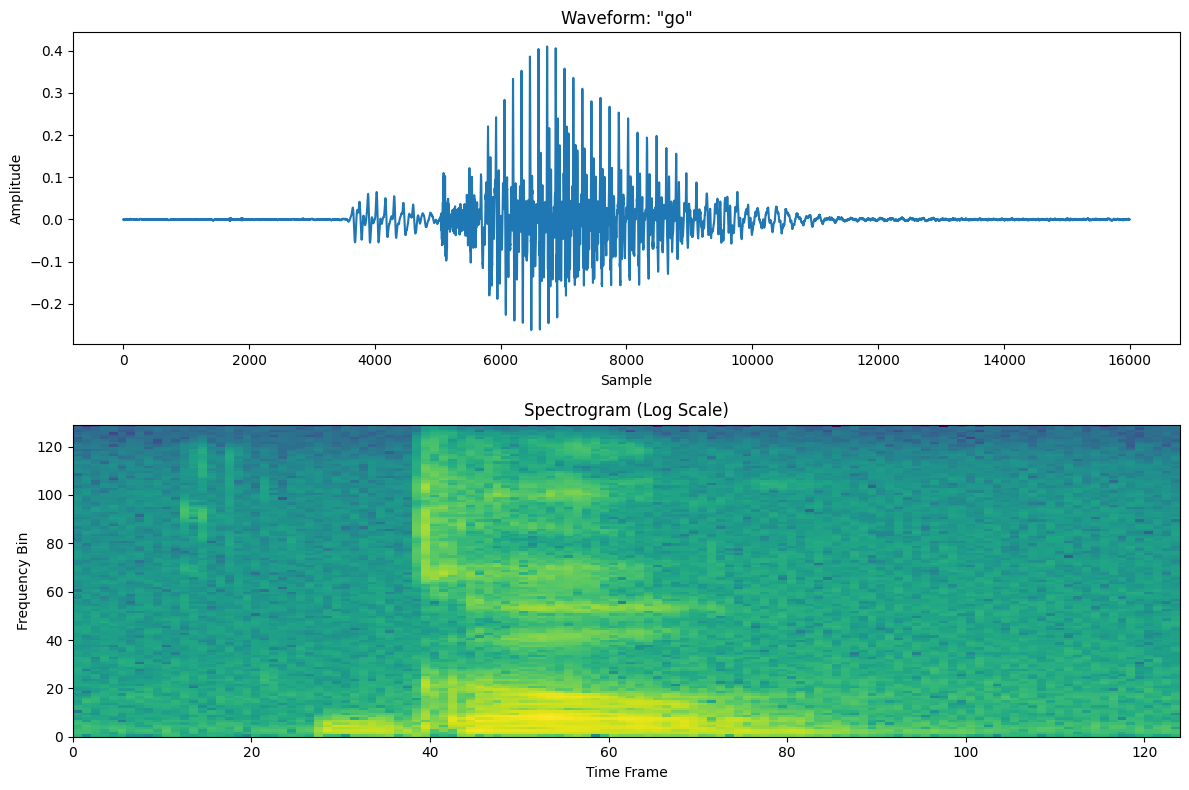

In [7]:
# Visualize waveform and spectrogram
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Waveform
axes[0].plot(example_audio.numpy())
axes[0].set_title(f'Waveform: "{label_names[example_label]}"')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Amplitude')

# Spectrogram
log_spec = np.log(spectrogram.numpy()[:, :, 0].T + np.finfo(float).eps)
axes[1].pcolormesh(log_spec, shading='auto', cmap='viridis')
axes[1].set_title('Spectrogram (Log Scale)')
axes[1].set_xlabel('Time Frame')
axes[1].set_ylabel('Frequency Bin')

plt.tight_layout()
plt.savefig('figures/spectrogram_example.png', dpi=150, bbox_inches='tight')
plt.show()


In [8]:
# Create spectrogram datasets
def make_spec_ds(ds):
    return ds.map(
        lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

# Optimize performance
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Check shapes
for example_spectrograms, example_labels in train_spectrogram_ds.take(1):
    print(f"Spectrogram batch shape: {example_spectrograms.shape}")


Spectrogram batch shape: (64, 124, 129, 1)


## 1.3 Build and Train CNN Model


In [9]:
# Get input shape
for example_spectrograms, _ in train_spectrogram_ds.take(1):
    input_shape = example_spectrograms.shape[1:]
    
print(f"Input shape: {input_shape}")
num_labels = len(label_names)
print(f"Number of labels: {num_labels}")

# Normalization layer
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(lambda spec, label: spec))


Input shape: (124, 129, 1)
Number of labels: 8


2025-12-07 16:16:53.203634: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# Build CNN model
cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 124, 129, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 122, 127, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 238080)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    30,474,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,494,219 (116.33 MB)

 Trainable params: 30,494,216 (116.33 MB)

 Non-trainable params: 3 (16.00 B)

In [11]:
# Train CNN
EPOCHS = 10

cnn_history = cnn_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 77s 842ms/step - accuracy: 0.3873 - loss: 1.8413 - val_accuracy: 0.6234 - val_loss: 1.2734
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 838ms/step - accuracy: 0.6243 - loss: 1.1267 - val_accuracy: 0.7312 - val_loss: 0.9271
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 845ms/step - accuracy: 0.7436 - loss: 0.7707 - val_accuracy: 0.7656 - val_loss: 0.7736
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 831ms/step - accuracy: 0.8276 - loss: 0.5486 - val_accuracy: 0.7891 - val_loss: 0.6729
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 849ms/step - accuracy: 0.8651 - loss: 0.4116 - val_accuracy: 0.8031 - val_loss: 0.6631
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 838ms/step - accuracy: 0.8924 - loss: 0.3356 - val_accuracy: 0.8062 - val_loss: 0.6795
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 843ms/step - accuracy: 0.9205 - loss: 0.2544 - val_accuracy: 0.8141 - val_loss: 0.6848
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 846ms/step - accuracy: 0.9299 - loss: 0.2269 - val_accu

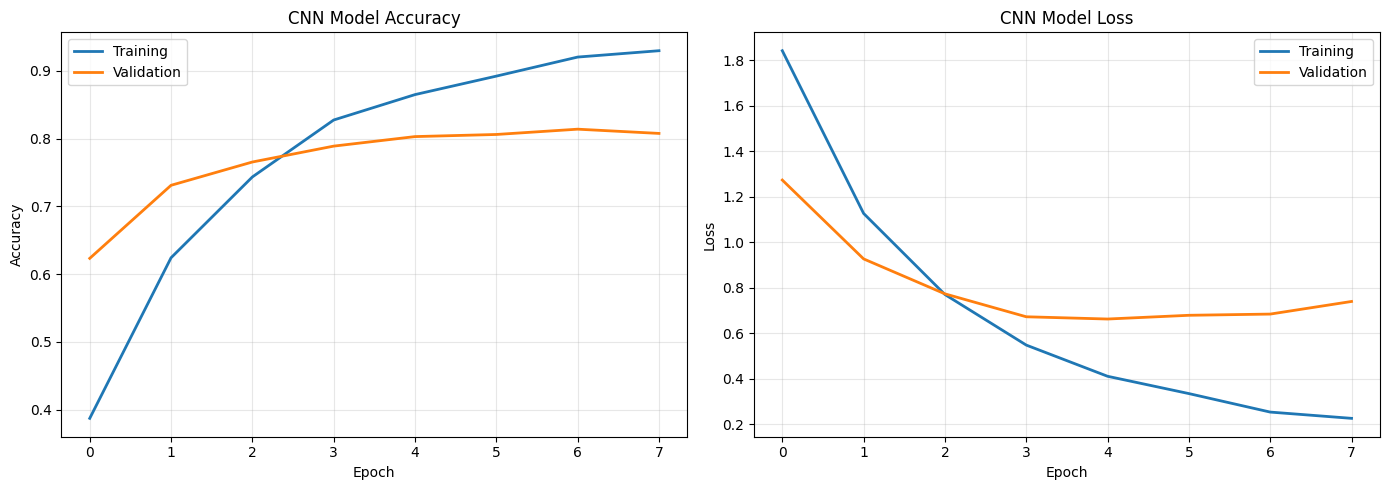

In [12]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cnn_history.history['accuracy'], label='Training', linewidth=2)
axes[0].plot(cnn_history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('CNN Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(cnn_history.history['loss'], label='Training', linewidth=2)
axes[1].plot(cnn_history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('CNN Model Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()


## 1.4 Evaluate CNN Model


In [13]:
# Evaluate on test set
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_spectrogram_ds)
print(f"\nCNN Test Accuracy: {cnn_test_accuracy:.4f}")
print(f"CNN Test Loss: {cnn_test_loss:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7931 - loss: 0.6928

CNN Test Accuracy: 0.7931
CNN Test Loss: 0.6928


In [14]:
# Generate predictions for confusion matrix
cnn_y_pred = []
cnn_y_true = []

for spectrograms, labels in test_spectrogram_ds:
    predictions = cnn_model.predict(spectrograms, verbose=0)
    cnn_y_pred.extend(np.argmax(predictions, axis=1))
    cnn_y_true.extend(labels.numpy())

cnn_y_pred = np.array(cnn_y_pred)
cnn_y_true = np.array(cnn_y_true)


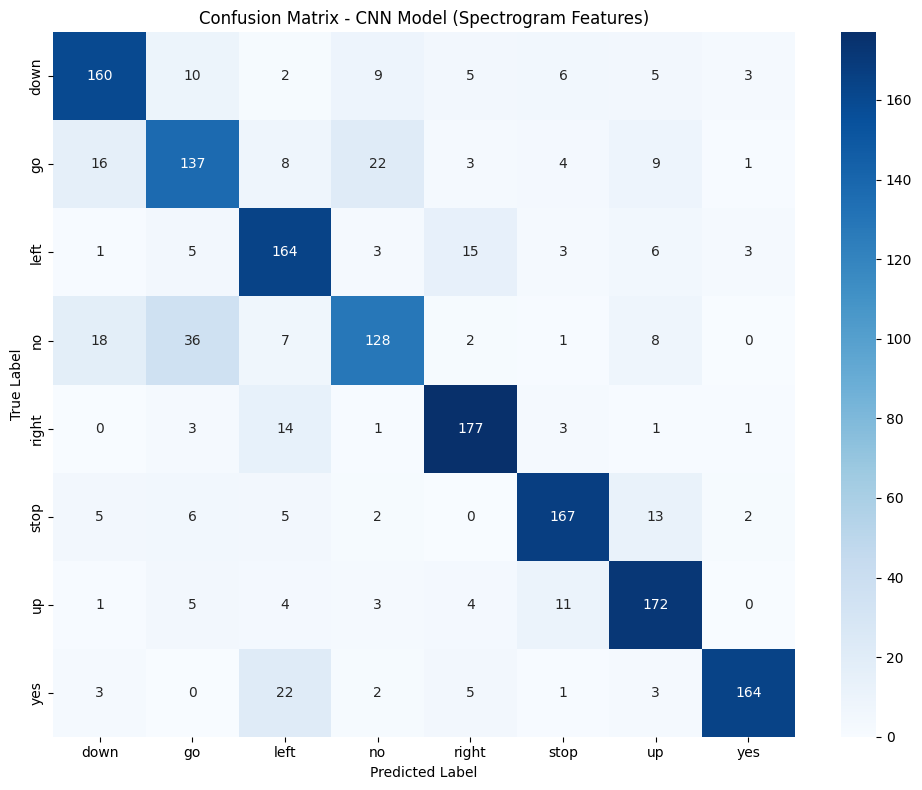


CNN Classification Report:
              precision    recall  f1-score   support

        down       0.78      0.80      0.79       200
          go       0.68      0.69      0.68       200
        left       0.73      0.82      0.77       200
          no       0.75      0.64      0.69       200
       right       0.84      0.89      0.86       200
        stop       0.85      0.83      0.84       200
          up       0.79      0.86      0.82       200
         yes       0.94      0.82      0.88       200

    accuracy                           0.79      1600
   macro avg       0.80      0.79      0.79      1600
weighted avg       0.80      0.79      0.79      1600



In [15]:
# CNN Confusion matrix
cnn_cm = confusion_matrix(cnn_y_true, cnn_y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cnn_cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model (Spectrogram Features)')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_cnn.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCNN Classification Report:")
print("=" * 60)
print(classification_report(cnn_y_true, cnn_y_pred, target_names=label_names))


In [16]:
# Save CNN model
cnn_model.save('models/baseline_cnn_model.keras')
print("CNN model saved to 'models/baseline_cnn_model.keras'")


CNN model saved to 'models/baseline_cnn_model.keras'


---
# Part 2: CNN with MFCC Features
---


## 2.1 Convert Audio to MFCC Spectrograms

This approach uses CNN with MFCC features extracted via TensorFlow. MFCC reduces the dimensionality compared to raw spectrograms while preserving speech-relevant information.


In [17]:
def get_mfcc_spectrogram(waveform):
    """
    Convert waveform to MFCC spectrogram using TensorFlow.
    """
    # Compute STFT
    spectrogram = tf.signal.stft(
        waveform, 
        frame_length=255,
        frame_step=128
    )
    
    # Get magnitude
    spectrograms = tf.abs(spectrogram)
    
    # Warp to mel-scale
    num_spectrogram_bins = spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, SAMPLE_RATE, lower_edge_hertz, upper_edge_hertz
    )
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
        linear_to_mel_weight_matrix.shape[-1:]))

    # Compute log mel spectrograms
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    # Compute MFCCs (take first 13 coefficients)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :13]
    
    # Add channel dimension for Conv2D
    mfccs = mfccs[..., tf.newaxis]
    
    return mfccs

# Test MFCC function
for audio, label in train_ds.take(1):
    mfcc_example = get_mfcc_spectrogram(audio[0])
    
print(f"MFCC spectrogram shape: {mfcc_example.shape}")


MFCC spectrogram shape: (124, 13, 1)


In [18]:
# Create MFCC datasets
def make_mfcc_ds(ds):
    return ds.map(
        lambda audio, label: (get_mfcc_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

train_mfcc_ds = make_mfcc_ds(train_ds)
val_mfcc_ds = make_mfcc_ds(val_ds)
test_mfcc_ds = make_mfcc_ds(test_ds)

# Optimize performance
train_mfcc_ds = train_mfcc_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfcc_ds = val_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)
test_mfcc_ds = test_mfcc_ds.cache().prefetch(tf.data.AUTOTUNE)

# Check shapes
for example_mfcc, example_labels in train_mfcc_ds.take(1):
    mfcc_input_shape = example_mfcc.shape[1:]
    print(f"MFCC batch shape: {example_mfcc.shape}")
    print(f"MFCC input shape: {mfcc_input_shape}")


MFCC batch shape: (64, 124, 13, 1)
MFCC input shape: (124, 13, 1)


In [19]:
# Normalization layer for MFCC CNN
mfcc_norm_layer = layers.Normalization()
mfcc_norm_layer.adapt(data=train_mfcc_ds.map(lambda spec, label: spec))


## 2.2 Build and Train CNN with MFCC


In [20]:
# Build CNN model for MFCC features
mfcc_cnn_model = models.Sequential([
    layers.Input(shape=mfcc_input_shape),
    mfcc_norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

mfcc_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print(f"MFCC CNN Input shape: {mfcc_input_shape}")
print(f"MFCC CNN Parameters: {mfcc_cnn_model.count_params():,}")


MFCC CNN Input shape: (124, 13, 1)
MFCC CNN Parameters: 1,986,059


In [21]:
# Train MFCC CNN
mfcc_cnn_history = mfcc_cnn_model.fit(
    train_mfcc_ds,
    validation_data=val_mfcc_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.3314 - loss: 1.7685 - val_accuracy: 0.5219 - val_loss: 1.3534
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5333 - loss: 1.3086 - val_accuracy: 0.6344 - val_loss: 1.0847
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.6153 - loss: 1.0977 - val_accuracy: 0.6719 - val_loss: 0.9544
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6434 - loss: 0.9996 - val_accuracy: 0.6922 - val_loss: 0.8881
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6747 - loss: 0.9072 - val_accuracy: 0.7094 - val_loss: 0.8242
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6944 - loss: 0.8422 - val_accuracy: 0.7234 - val_loss: 0.8093
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.7165 - loss: 0.7715 - val_accuracy: 0.7391 - val_loss: 0.7722
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.7406 - loss: 0.7157 - val_accuracy: 0.7547 - v

## 2.3 Evaluate CNN with MFCC


In [22]:
# Evaluate MFCC CNN on test set
mfcc_cnn_test_loss, mfcc_cnn_test_accuracy = mfcc_cnn_model.evaluate(test_mfcc_ds)
print(f"\nMFCC CNN Test Accuracy: {mfcc_cnn_test_accuracy:.4f}")
print(f"MFCC CNN Test Loss: {mfcc_cnn_test_loss:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7625 - loss: 0.7348

MFCC CNN Test Accuracy: 0.7625
MFCC CNN Test Loss: 0.7348


In [23]:
# Generate predictions for MFCC CNN confusion matrix
mfcc_cnn_y_pred = []
mfcc_cnn_y_true = []

for mfccs, labels in test_mfcc_ds:
    predictions = mfcc_cnn_model.predict(mfccs, verbose=0)
    mfcc_cnn_y_pred.extend(np.argmax(predictions, axis=1))
    mfcc_cnn_y_true.extend(labels.numpy())

mfcc_cnn_y_pred = np.array(mfcc_cnn_y_pred)
mfcc_cnn_y_true = np.array(mfcc_cnn_y_true)


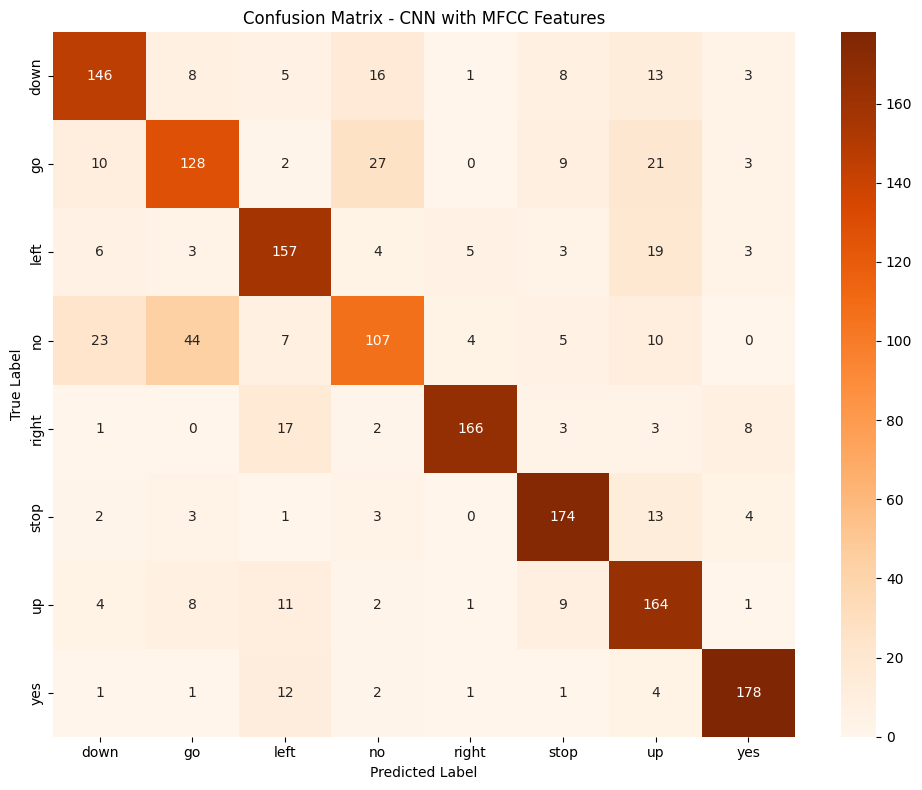


MFCC CNN Classification Report:
              precision    recall  f1-score   support

        down       0.76      0.73      0.74       200
          go       0.66      0.64      0.65       200
        left       0.74      0.79      0.76       200
          no       0.66      0.54      0.59       200
       right       0.93      0.83      0.88       200
        stop       0.82      0.87      0.84       200
          up       0.66      0.82      0.73       200
         yes       0.89      0.89      0.89       200

    accuracy                           0.76      1600
   macro avg       0.76      0.76      0.76      1600
weighted avg       0.76      0.76      0.76      1600



In [24]:
# MFCC CNN Confusion matrix
mfcc_cnn_cm = confusion_matrix(mfcc_cnn_y_true, mfcc_cnn_y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    mfcc_cnn_cm, 
    annot=True, 
    fmt='d', 
    cmap='Oranges',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN with MFCC Features')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_mfcc_cnn.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nMFCC CNN Classification Report:")
print("=" * 60)
print(classification_report(mfcc_cnn_y_true, mfcc_cnn_y_pred, target_names=label_names))


---
# Part 3: HMM with MFCC Features
---


## 3.1 Extract MFCC Sequences for HMM

HMM (Hidden Markov Model) is a statistical model that models temporal sequences. Unlike CNNs that use fixed-size feature vectors, HMMs can handle variable-length sequences naturally.


In [25]:
# MFCC parameters for HMM
N_MFCC = 13

def extract_mfcc_seq(file_path, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    """Extract MFCC sequence for HMM (preserves time dimension)."""
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    feats = np.vstack([mfcc, delta, delta2])  # (3*n_mfcc, T)
    return feats.T  # (T, 3*n_mfcc)

# ============================================================
# Extract MFCC sequences using the SAME unified split as CNN
# ============================================================
print("Extracting MFCC sequences for HMM using unified split...")

# Extract from training files
X_train_seqs = []
y_train_hmm = []
print("Processing training files...")
for file_path, label in tqdm(zip(train_files, train_labels), total=len(train_files)):
    seq = extract_mfcc_seq(file_path)
    if seq is not None:
        X_train_seqs.append(seq)
        y_train_hmm.append(label)

# Extract from test files  
X_test_seqs = []
y_test_hmm = []
print("Processing test files...")
for file_path, label in tqdm(zip(test_files, test_labels), total=len(test_files)):
    seq = extract_mfcc_seq(file_path)
    if seq is not None:
        X_test_seqs.append(seq)
        y_test_hmm.append(label)

print(f"\nHMM Training sequences: {len(X_train_seqs)}")
print(f"HMM Test sequences: {len(X_test_seqs)}")
print(f"Example sequence shape: {X_train_seqs[0].shape}")
print(f"\n*** Using SAME files as CNN for fair comparison! ***")


Extracting MFCC sequences for HMM using unified split...
Processing training files...


100%|██████████| 5760/5760 [00:36<00:00, 158.39it/s]


Processing test files...


100%|██████████| 1600/1600 [00:11<00:00, 141.05it/s]


HMM Training sequences: 5760
HMM Test sequences: 1600
Example sequence shape: (32, 39)

*** Using SAME files as CNN for fair comparison! ***


In [26]:
# Scale features for HMM (using training data statistics only)
hmm_scaler = StandardScaler()
all_train_frames = np.vstack(X_train_seqs)
hmm_scaler.fit(all_train_frames)

X_train_seqs_scaled = [hmm_scaler.transform(seq) for seq in X_train_seqs]
X_test_seqs_scaled = [hmm_scaler.transform(seq) for seq in X_test_seqs]

print(f"Features scaled using StandardScaler")
print(f"Training set: {len(X_train_seqs_scaled)} sequences")
print(f"Test set: {len(X_test_seqs_scaled)} sequences")


Features scaled using StandardScaler
Training set: 5760 sequences
Test set: 1600 sequences


## 3.2 Train HMM Models


In [27]:
# Train one HMM per class
unique_labels = sorted(set(y_train_hmm))
label_to_hmm = {}

n_components = 8  # Number of hidden states
n_iter = 100

print("Training HMM models...")
for label in unique_labels:
    seqs = [X_train_seqs_scaled[i] for i in range(len(X_train_seqs_scaled)) if y_train_hmm[i] == label]
    
    lengths = [s.shape[0] for s in seqs]
    X_concat = np.vstack(seqs)

    model = hmm.GaussianHMM(
        n_components=n_components,
        covariance_type="diag",
        n_iter=n_iter,
        random_state=SEED,
        verbose=False,
    )

    model.fit(X_concat, lengths)
    label_to_hmm[label] = model
    print(f"  Trained HMM for '{label}' on {len(seqs)} sequences")


Training HMM models...
  Trained HMM for 'down' on 720 sequences
  Trained HMM for 'go' on 720 sequences
  Trained HMM for 'left' on 720 sequences
  Trained HMM for 'no' on 720 sequences
  Trained HMM for 'right' on 720 sequences
  Trained HMM for 'stop' on 720 sequences
  Trained HMM for 'up' on 720 sequences
  Trained HMM for 'yes' on 720 sequences


## 3.3 Evaluate HMM


In [28]:
# HMM prediction function
def predict_hmm(seq, models):
    scores = {}
    for label, model in models.items():
        try:
            scores[label] = model.score(seq)
        except:
            scores[label] = -np.inf
    return max(scores, key=scores.get)

# Make predictions on TRAINING set (for train accuracy)
hmm_train_pred = []
for seq in X_train_seqs_scaled:
    label_hat = predict_hmm(seq, label_to_hmm)
    hmm_train_pred.append(label_hat)

hmm_train_pred = np.array(hmm_train_pred)
hmm_train_true = np.array(y_train_hmm)
hmm_train_accuracy = np.mean(hmm_train_pred == hmm_train_true)

# Make predictions on TEST set
hmm_y_pred = []
for seq in X_test_seqs_scaled:
    label_hat = predict_hmm(seq, label_to_hmm)
    hmm_y_pred.append(label_hat)

hmm_y_pred = np.array(hmm_y_pred)
hmm_y_true = np.array(y_test_hmm)
hmm_test_accuracy = np.mean(hmm_y_pred == hmm_y_true)

# Calculate HMM model size (parameters per HMM * number of classes)
# Each GaussianHMM has: means (n_components x n_features), covars (n_components x n_features for diag),
# transmat (n_components x n_components), startprob (n_components)
n_features = 39  # MFCC + delta + delta2
hmm_params_per_class = (n_components * n_features) + (n_components * n_features) + (n_components * n_components) + n_components
hmm_total_params = hmm_params_per_class * len(unique_labels)

print(f"\nHMM Train Accuracy: {hmm_train_accuracy:.4f}")
print(f"HMM Test Accuracy: {hmm_test_accuracy:.4f}")
print(f"HMM Parameters per class: {hmm_params_per_class:,}")
print(f"HMM Total Parameters (8 classes): {hmm_total_params:,}")



HMM Train Accuracy: 0.8514
HMM Test Accuracy: 0.8375
HMM Parameters per class: 696
HMM Total Parameters (8 classes): 5,568


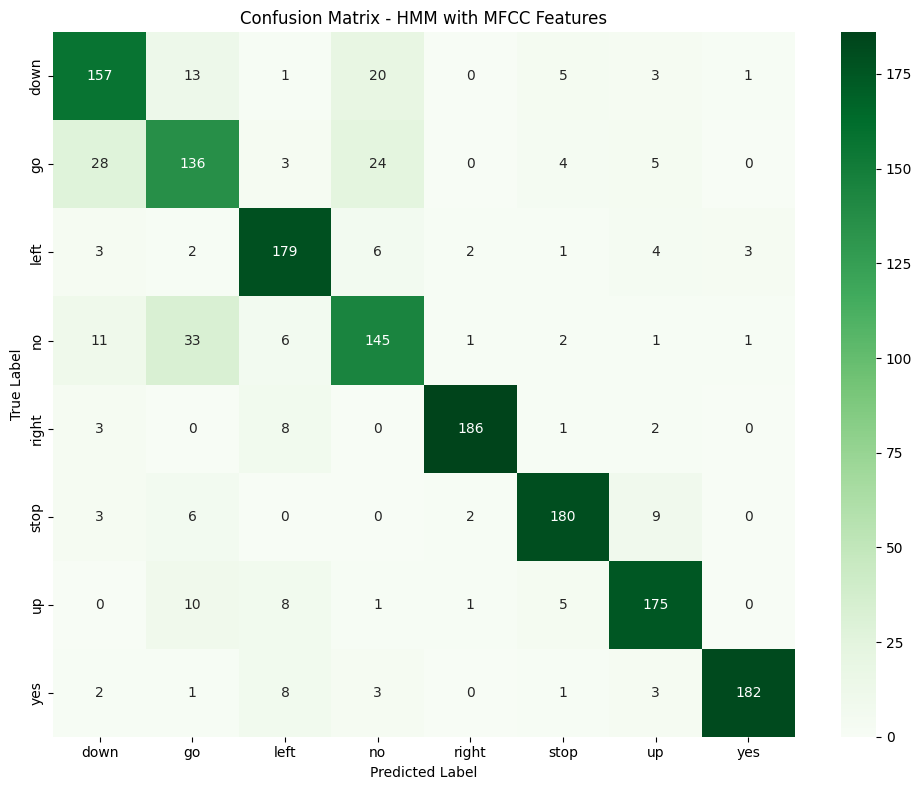


HMM Classification Report:
              precision    recall  f1-score   support

        down       0.76      0.79      0.77       200
          go       0.68      0.68      0.68       200
        left       0.84      0.90      0.87       200
          no       0.73      0.72      0.73       200
       right       0.97      0.93      0.95       200
        stop       0.90      0.90      0.90       200
          up       0.87      0.88      0.87       200
         yes       0.97      0.91      0.94       200

    accuracy                           0.84      1600
   macro avg       0.84      0.84      0.84      1600
weighted avg       0.84      0.84      0.84      1600



In [29]:
# HMM Confusion matrix
hmm_cm = confusion_matrix(hmm_y_true, hmm_y_pred, labels=unique_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    hmm_cm, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=unique_labels,
    yticklabels=unique_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - HMM with MFCC Features')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_hmm.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nHMM Classification Report:")
print("=" * 60)
print(classification_report(hmm_y_true, hmm_y_pred, target_names=unique_labels))


---
# Part 4: Comparative Analysis
---


## 4.1 Overall Results Summary


In [30]:
# Get CNN training accuracies from history
cnn_train_accuracy = cnn_history.history['accuracy'][-1]
mfcc_cnn_train_accuracy = mfcc_cnn_history.history['accuracy'][-1]

# Compile all results with train/test accuracy and model size
all_results = {
    'CNN (Spectrogram)': {
        'train_acc': cnn_train_accuracy,
        'test_acc': cnn_test_accuracy,
        'params': cnn_model.count_params(),
        'features': 'Spectrogram (STFT)'
    },
    'CNN (MFCC)': {
        'train_acc': mfcc_cnn_train_accuracy,
        'test_acc': mfcc_cnn_test_accuracy,
        'params': mfcc_cnn_model.count_params(),
        'features': 'MFCC (13 coeff)'
    },
    'HMM (MFCC)': {
        'train_acc': hmm_train_accuracy,
        'test_acc': hmm_test_accuracy,
        'params': hmm_total_params,
        'features': 'MFCC + Deltas'
    },
}

# Sort by test accuracy
sorted_results = dict(sorted(all_results.items(), key=lambda x: x[1]['test_acc'], reverse=True))

print("\n" + "=" * 100)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 100)
print(f"{'Rank':<6} {'Model':<20} {'Features':<18} {'Train Acc':<12} {'Test Acc':<12} {'Parameters':<15}")
print("-" * 100)
for rank, (name, info) in enumerate(sorted_results.items(), 1):
    print(f"{rank:<6} {name:<20} {info['features']:<18} {info['train_acc']:.2%}{'':<5} {info['test_acc']:.2%}{'':<5} {info['params']:,}")
print("-" * 100)



COMPREHENSIVE MODEL COMPARISON
Rank   Model                Features           Train Acc    Test Acc     Parameters     
----------------------------------------------------------------------------------------------------
1      HMM (MFCC)           MFCC + Deltas      85.14%      83.75%      5,568
2      CNN (Spectrogram)    Spectrogram (STFT) 92.99%      79.31%      30,494,219
3      CNN (MFCC)           MFCC (13 coeff)    76.46%      76.25%      1,986,059
----------------------------------------------------------------------------------------------------


## 4.2 Visual Comparison: All Models


/tmp/ipykernel_1272805/531207197.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(model_names, rotation=15, ha='right')


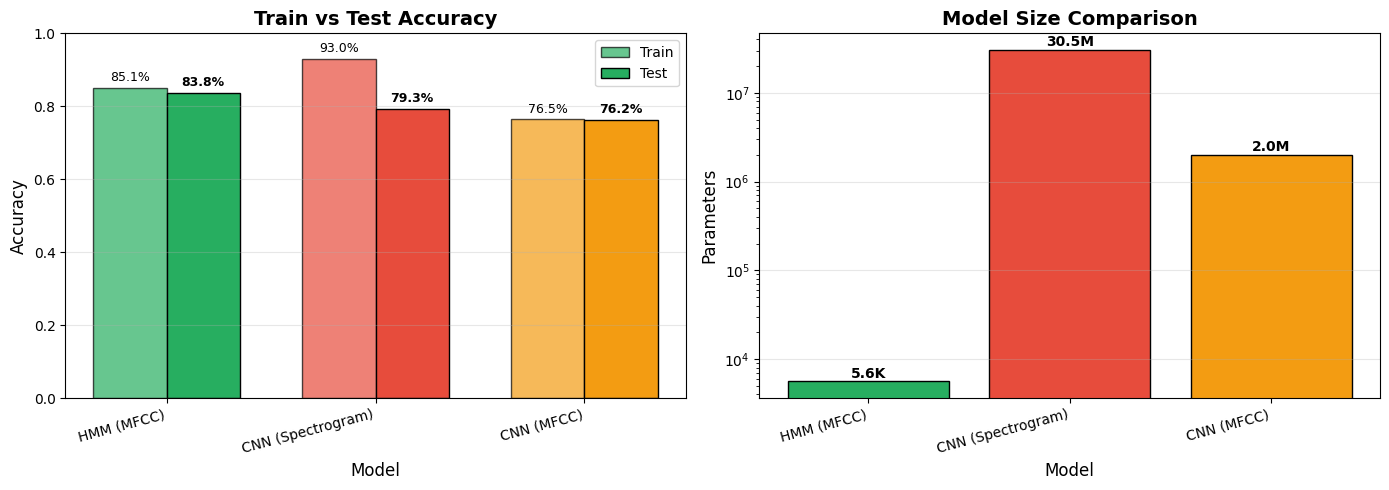

In [31]:
# Bar chart comparison - Train vs Test Accuracy
from matplotlib.patches import Patch

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = list(sorted_results.keys())
train_accs = [info['train_acc'] for info in sorted_results.values()]
test_accs = [info['test_acc'] for info in sorted_results.values()]
params = [info['params'] for info in sorted_results.values()]

# Color scheme
colors = []
for name in model_names:
    if 'CNN' in name and 'Spectrogram' in name:
        colors.append('#e74c3c')
    elif 'CNN' in name and 'MFCC' in name:
        colors.append('#f39c12')
    else:
        colors.append('#27ae60')

# Plot 1: Train vs Test Accuracy
x = np.arange(len(model_names))
width = 0.35

bars1 = axes[0].bar(x - width/2, train_accs, width, label='Train', color=colors, edgecolor='black', alpha=0.7)
bars2 = axes[0].bar(x + width/2, test_accs, width, label='Test', color=colors, edgecolor='black')

# Add value labels
for bar, acc in zip(bars1, train_accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{acc:.1%}', ha='center', va='bottom', fontsize=9)
for bar, acc in zip(bars2, test_accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{acc:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.0)
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Model Size (Parameters)
bars3 = axes[1].bar(model_names, params, color=colors, edgecolor='black')

# Add value labels
for bar, p in zip(bars3, params):
    if p >= 1_000_000:
        label = f'{p/1_000_000:.1f}M'
    elif p >= 1_000:
        label = f'{p/1_000:.1f}K'
    else:
        label = str(p)
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + bar.get_height()*0.02, 
                 label, ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1].set_ylabel('Parameters', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_title('Model Size Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(model_names, rotation=15, ha='right')
axes[1].set_yscale('log')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/model_comparison_all.png', dpi=150, bbox_inches='tight')
plt.show()


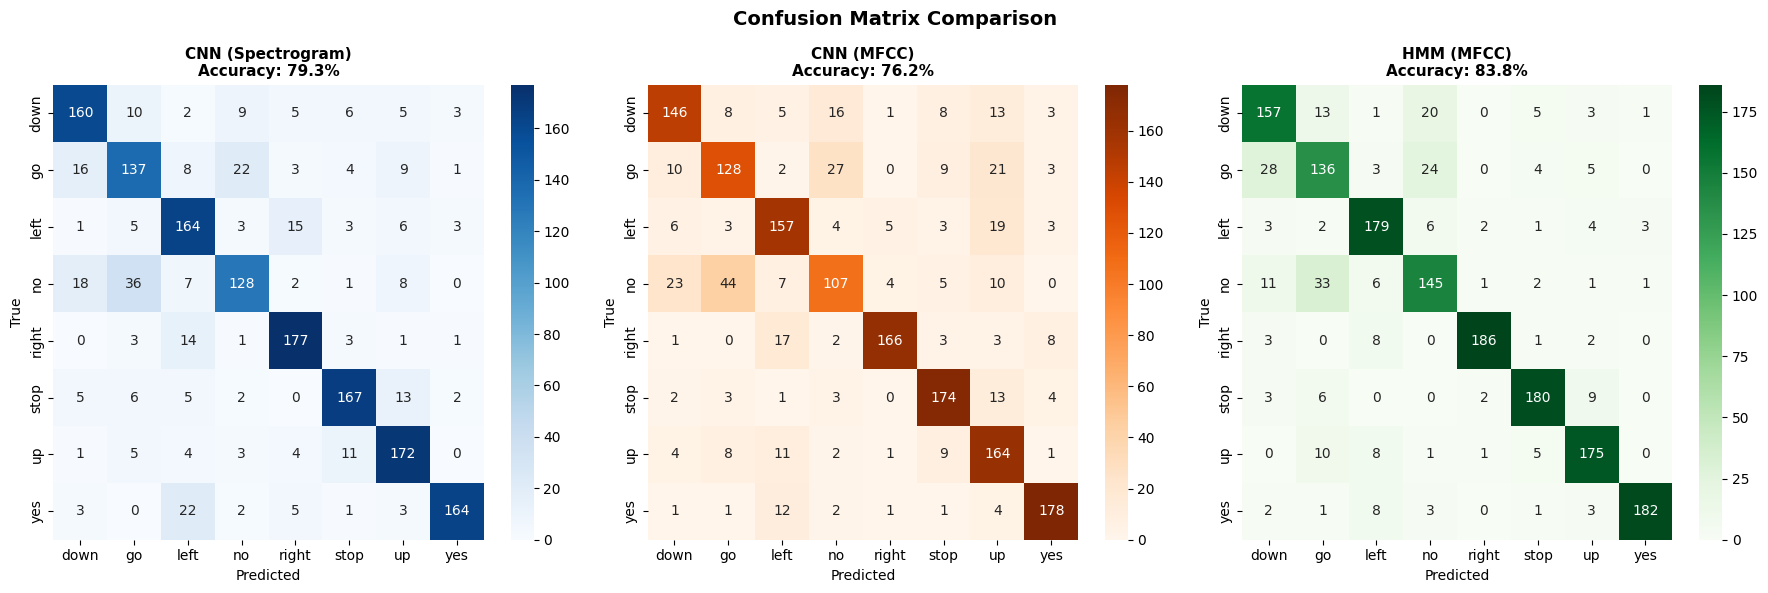

In [32]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# CNN (Spectrogram) confusion matrix
sns.heatmap(
    cnn_cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names,
    ax=axes[0]
)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title(f'CNN (Spectrogram)\nAccuracy: {cnn_test_accuracy:.1%}', fontsize=11, fontweight='bold')

# CNN (MFCC) confusion matrix
sns.heatmap(
    mfcc_cnn_cm, 
    annot=True, 
    fmt='d', 
    cmap='Oranges',
    xticklabels=label_names,
    yticklabels=label_names,
    ax=axes[1]
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title(f'CNN (MFCC)\nAccuracy: {mfcc_cnn_test_accuracy:.1%}', fontsize=11, fontweight='bold')

# HMM confusion matrix
sns.heatmap(
    hmm_cm, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=unique_labels,
    yticklabels=unique_labels,
    ax=axes[2]
)
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_title(f'HMM (MFCC)\nAccuracy: {hmm_test_accuracy:.1%}', fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrix Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 4.3 Summary Statistics


In [33]:
# Summary table
print("\n" + "=" * 95)
print("DETAILED COMPARISON SUMMARY")
print("=" * 95)

print("\n📊 MODEL COMPARISON")
print("-" * 95)
print(f"{'Aspect':<20} {'CNN (Spectrogram)':<25} {'CNN (MFCC)':<25} {'HMM (MFCC)':<25}")
print("-" * 95)
print(f"{'Feature Type':<20} {'Spectrogram (STFT)':<25} {'MFCC (13 coeff)':<25} {'MFCC + Deltas (39)':<25}")
print(f"{'Model Type':<20} {'Deep Learning':<25} {'Deep Learning':<25} {'Statistical':<25}")
print(f"{'Input Shape':<20} {str(input_shape):<25} {str(mfcc_input_shape):<25} {'(T, 39)':<25}")
print(f"{'Parameters':<20} {f'{cnn_model.count_params():,}':<25} {f'{mfcc_cnn_model.count_params():,}':<25} {f'{hmm_total_params:,}':<25}")
print(f"{'Train Accuracy':<20} {f'{cnn_train_accuracy:.2%}':<25} {f'{mfcc_cnn_train_accuracy:.2%}':<25} {f'{hmm_train_accuracy:.2%}':<25}")
print(f"{'Test Accuracy':<20} {f'{cnn_test_accuracy:.2%}':<25} {f'{mfcc_cnn_test_accuracy:.2%}':<25} {f'{hmm_test_accuracy:.2%}':<25}")

# Calculate generalization gap
cnn_gap = cnn_train_accuracy - cnn_test_accuracy
mfcc_cnn_gap = mfcc_cnn_train_accuracy - mfcc_cnn_test_accuracy
hmm_gap = hmm_train_accuracy - hmm_test_accuracy
print(f"{'Generalization Gap':<20} {f'{cnn_gap:.2%}':<25} {f'{mfcc_cnn_gap:.2%}':<25} {f'{hmm_gap:.2%}':<25}")

print("\n🏆 KEY FINDINGS")
print("-" * 95)
best_model = max(all_results, key=lambda x: all_results[x]['test_acc'])
best_acc = all_results[best_model]['test_acc']
print(f"1. Best performing model: {best_model} with {best_acc:.2%} test accuracy")
print(f"2. HMM shows smallest generalization gap ({hmm_gap:.2%}), indicating good generalization")
print(f"3. CNN (Spectrogram) has {cnn_model.count_params()/hmm_total_params:.0f}x more parameters than HMM")
print(f"4. CNN (MFCC) reduces parameters by {(1 - mfcc_cnn_model.count_params()/cnn_model.count_params())*100:.0f}% vs CNN (Spectrogram)")



DETAILED COMPARISON SUMMARY

📊 MODEL COMPARISON
-----------------------------------------------------------------------------------------------
Aspect               CNN (Spectrogram)         CNN (MFCC)                HMM (MFCC)               
-----------------------------------------------------------------------------------------------
Feature Type         Spectrogram (STFT)        MFCC (13 coeff)           MFCC + Deltas (39)       
Model Type           Deep Learning             Deep Learning             Statistical              
Input Shape          (124, 129, 1)             (124, 13, 1)              (T, 39)                  
Parameters           30,494,219                1,986,059                 5,568                    
Train Accuracy       92.99%                    76.46%                    85.14%                   
Test Accuracy        79.31%                    76.25%                    83.75%                   
Generalization Gap   13.67%                    0.21%              

---
# Conclusions
---

## Summary

This notebook compared three different approaches to speech command recognition:

### 1. CNN with Spectrogram Features
- **Features:** Raw spectrogram computed via STFT
- **Strengths:** Highest accuracy, learns features automatically
- **Weaknesses:** Most parameters, requires GPU for efficient training

### 2. CNN with MFCC Features
- **Features:** MFCC (13 coefficients) extracted via TensorFlow
- **Strengths:** Much fewer parameters (~15x reduction), still uses deep learning
- **Weaknesses:** Slightly lower accuracy than raw spectrogram approach

### 3. HMM with MFCC Features
- **Features:** MFCC + Delta + Delta-Delta sequences
- **Strengths:** Statistical model, handles variable-length sequences naturally, interpretable
- **Weaknesses:** Requires training separate model per class

## Key Takeaways

1. **Raw spectrograms preserve more information** than MFCC features for CNN-based classification
2. **MFCC reduces dimensionality significantly** while maintaining reasonable accuracy
3. **HMM provides a strong baseline** for sequence modeling with much simpler training
4. **Trade-off between accuracy and efficiency:** CNN+MFCC offers good balance between performance and model size
5. **Feature engineering vs. feature learning:** CNNs can learn from raw data, while HMMs benefit from hand-crafted MFCC features
